This is the notebook I used for practicing K-means and SVM (I actually executed most on the lab computers). This is all pretty messy so I'd use it just as reference to see how I did it 

In [9]:
import tarfile
import urllib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from numpy import sqrt
from sklearn.svm import SVC
import pickle
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.metrics import cluster
import sklearn.metrics
from pathlib import Path

In [8]:
csv = pd.read_csv('FinalDataset.csv')
newdf = pd.DataFrame(csv)
errordf = newdf[newdf.index.notnull()]
area=[]
for a in errordf['img_h']:
    if a == 972:
        area.append(1259712)
    if a == 912:
        area.append(1108992)
    if a ==450:
        area.append(270000)
errordf['img_area'] = area
#Convert all geometric values to ratios
errordf['Area_r'] = errordf['Area']/(sqrt(errordf['img_area'])/100)
errordf['Perimeter_r'] = errordf['Perimeter']/(sqrt(errordf['img_area'])/100)
errordf['Major_axis_length_r'] = errordf['Major_axis_length']/(sqrt(errordf['img_area'])/100)
errordf['Minor_axis_length_r'] = errordf['Minor_axis_length']/(sqrt(errordf['img_area'])/100)
errordf['Equivalent_diameter_r'] = errordf['Equivalent_diameter']/(sqrt(errordf['img_area'])/100)

#I use the image heights to select between datasets, so use ==450 for SAPS or !=450 for GPP or neither for combined
#errordf = errordf[errordf['img_h']==450]
errordf

,Unnamed: 0,img_h,error,Clump,Misread,Area,Perimeter,Solidity,Major_axis_length,Minor_axis_length,...,Energy,Correlation,Bounding_box,Entropy,img_area,Area_r,Perimeter_r,Major_axis_length_r,Minor_axis_length_r,Equivalent_diameter_r
0,Abies cephalonica1-1,972,0,0,0,185475,2148.351514,0.852617,674.933044,420.156991,...,0.339303,0.963486,"(56, 763, 690, 1209)",4.849428,1259712,16525.314997,191.412242,60.134687,37.434838,43.297430
1,Abies cephalonica1-1,972,0,0,0,136558,1678.628642,0.899319,538.347768,359.666465,...,0.312159,0.980137,"(339, 372, 864, 752)",5.172168,1259712,12166.944145,149.561219,47.965313,32.045298,37.151641
2,Abies nordmanniana1-1,972,0,0,0,565318,2969.695706,0.991946,946.564642,767.424770,...,0.159598,0.983691,"(145, 157, 887, 1061)",5.953881,1259712,50368.286956,264.591762,84.336320,68.375447,75.590259
3,Abies religiosa1-1,972,1,0,1,5115,352.090404,0.863145,117.359585,59.842103,...,0.351071,0.917417,"(34, 547, 154, 615)",5.272603,1259712,455.732504,31.370292,10.456418,5.331768,7.190221
4,Abies religiosa1-1,972,0,0,0,155620,1725.699710,0.904662,562.851959,383.508423,...,0.347042,0.989556,"(228, 267, 771, 710)",5.349896,1259712,13865.316187,153.755122,50.148569,34.169551,39.659947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9842,Zornia curvata1-1,972,1,1,0,76421,1303.851947,0.904005,367.389517,281.161273,...,0.330122,0.955168,"(229, 494, 547, 856)",5.222733,1259712,6808.901994,116.169641,32.733401,25.050700,27.792383
9843,Zornia curvata1-1,972,1,0,1,3779,377.948268,0.714367,129.472859,47.747114,...,0.522279,0.930787,"(789, 549, 918, 613)",3.910655,1259712,336.698560,33.674157,11.535678,4.254137,6.180276
9844,Zornia curvata1-1,972,1,0,1,1517,165.781746,0.913855,57.978301,36.321790,...,0.333257,0.898527,"(813, 1139, 855, 1196)",4.391925,1259712,135.160549,14.770700,5.165708,3.236172,3.915725
9845,Zornia piurensis1-2,972,0,0,0,60357,989.761543,0.976398,286.656299,269.424926,...,0.237711,0.927109,"(350, 467, 637, 745)",5.678020,1259712,5377.643549,88.185045,25.540292,24.005024,24.699221


In [7]:
#Trains an SVM model for error detection

csv = pd.read_csv('FinalDataset.csv')
newdf = pd.DataFrame(csv)
errordf = newdf[newdf.index.notnull()]
errordf['PE']=errordf['P/E']
errordf['Area_r'] = errordf['Area']/(sqrt(errordf['img_area'])/100)
errordf['Perimeter_r'] = errordf['Perimeter']/(sqrt(errordf['img_area'])/100)
errordf['Major_axis_length_r'] = errordf['Major_axis_length']/(sqrt(errordf['img_area'])/100)
errordf['Minor_axis_length_r'] = errordf['Minor_axis_length']/(sqrt(errordf['img_area'])/100)
errordf['Equivalent_diameter_r'] = errordf['Equivalent_diameter']/(sqrt(errordf['img_area'])/100)
#ppp = ['PE','phyla','polarity','order','family','2D_shape','3D_shape','class','aperture_type','aperture_features','dispersal_unit']#,'viscin','ubisch']
fulldf = pd.DataFrame()
new=[]

ppp=['error']

for a in ppp:
     for b in np.linspace(0.000001,0.0001,10):
        newdf=errordf#[errordf['error']==0]
        newdf=newdf[newdf['img_h']==450]
        #Remove labels which have fewer than 30 examples
        newdf = newdf.groupby(a).filter(lambda x: len(x) >= 30)
        newdf = newdf[[a,'Area_r','Eccentricity','Equivalent_diameter_r','Extent','Major_axis_length_r','Minor_axis_length_r','Perimeter_r','ASM','Contrast','Correlation','Dissimilarity','Energy','Entropy','Homogeneity','Solidity']]#.set_index('comb')
        #remove NaN
        newdf = newdf.set_index(a)
        newdf = newdf[newdf.index.notnull()]
        #Drop all non-labelled values which are not NaN
        try:
            newdf = newdf.drop('-')
        except:
            newdf = newdf
        try:
            newdf = newdf.drop('no suitable term')
        except:
            newdf = newdf
        try:
            newdf = newdf.drop('unplaced')
        except:
            newdf = newdf
        label_encoder = LabelEncoder()
        #KFolds - Very important! Splits the dataset 5 times into training and testing data for cross-validation purposes
        kf = KFold(n_splits=5, random_state=None, shuffle=True)
        rand_scores = []
        rands = []
        kfolds = []
        #The 'pipeline' is really useful to define so you can succinctly define your ML model and make predictions
        pipe = Pipeline([("scaler", MinMaxScaler()),("SVM",SVC(C=b,gamma='scale',kernel='rbf',probability=True))])
        #This was sort of a mannual K-folds loop, i was just trying to make sure results were valid. You could remove this
        for c in range(10):
            train_img, test_img, train_lbl, test_lbl = train_test_split(newdf.values, newdf.index, test_size=1/7.0, random_state=None)
            pipe["scaler"].fit_transform(train_img,train_lbl)
         #Could remove this try as well i was just working around an error which doesn't happen anymore
            try:
                pipe.fit(newdf.values,newdf.index)
            except:
                continue
         #Measures ARI and appends to dataframe - I used balanced accuracy also in final executions for further validation
            kfolds.append(model_selection.cross_val_score(pipe, train_img, train_lbl, scoring='adjusted_rand_score', cv=kf, n_jobs=-1).mean())#sklearn.metrics.adjusted_rand_score(labels,true_labels))
            pred=pipe.predict(pipe["scaler"].transform(test_img))
            rands.append(sklearn.metrics.adjusted_rand_score(pred,test_lbl))
        rand_scores.append(newdf.index.size)
        rand_scores.append(sum(kfolds)/len(kfolds))
        rand_scores.append(sum(rands)/len(rands))
        fulldf=fulldf.append(pd.Series(rand_scores, name=b))
        #You can save the models using pickle to make predicitons from again - I would use the next cell for this
        #filename = f'SVM_{b}_model.sav'
        #pickle.dump(pipe, open(filename, 'wb'))
#fulldf.to_csv('output.csv')
fulldf

,0,1,2
10,9847.0,0.794714,0.132791


In [92]:
#This is the same as the cell above but utilises GridSearchCV - an exhaustive search of rtying lots of different combinations of variables
#Annotations same as above
csv = pd.read_csv('FinalDataset.csv')
newdf = pd.DataFrame(csv)
errordf = newdf[newdf.index.notnull()]
errordf['PE']=errordf['P/E']
errordf['Area_r'] = errordf['Area']/(sqrt(errordf['img_area'])/100)
errordf['Perimeter_r'] = errordf['Perimeter']/(sqrt(errordf['img_area'])/100)
errordf['Major_axis_length_r'] = errordf['Major_axis_length']/(sqrt(errordf['img_area'])/100)
errordf['Minor_axis_length_r'] = errordf['Minor_axis_length']/(sqrt(errordf['img_area'])/100)
errordf['Equivalent_diameter_r'] = errordf['Equivalent_diameter']/(sqrt(errordf['img_area'])/100)
#ppp = ['PE','phyla','polarity','order','family','2D_shape','3D_shape','class','aperture_type','aperture_features','dispersal_unit']#,'viscin','ubisch']
fulldf = pd.DataFrame()
new=[]
comb = []

for b in errordf.values:
    #print(b)
    if b[4] == 1.0:
        comb.append(2.0) 
    elif b[5] == 1.0:
        comb.append(1.0)
    else:
        comb.append(0.0)
errordf['comb'] = comb
ppp=['error']

l= [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1]

for a in ppp:
     for b in np.linspace(0.000001,0.0001,10):
        newdf=errordf#[errordf['Clump']==0]
        newdf=newdf[newdf['img_h']==450]
        #newdf = newdf.groupby(a).filter(lambda x: len(x) >= 30)
        newdf = newdf[[a,'Area','Eccentricity','Equivalent_diameter','Extent','Major_axis_length','Minor_axis_length','Perimeter','ASM','Contrast','Correlation','Dissimilarity','Energy','Entropy','Homogeneity','Solidity']]#.set_index('comb')
        newdf = newdf.set_index(a)
        newdf = newdf[newdf.index.notnull()]
        newdf

        try:
            newdf = newdf.drop('-')
        except:
            newdf = newdf
        try:
            newdf = newdf.drop('no suitable term')
        except:
            newdf = newdf
        try:
            newdf = newdf.drop('unplaced')
        except:
            newdf = newdf

        label_encoder = LabelEncoder()
        kf = KFold(n_splits=5, random_state=None, shuffle=True)
        
        pipe = Pipeline([("scaler", MinMaxScaler()),("SVM",SVC(probability=True))])
        train_img, test_img, train_lbl, test_lbl = train_test_split(newdf.values, newdf.index, test_size=1/7.0, random_state=None)
        #Paramaters to run through need to be defined for GridSearchCV - there are different kernels and parameters specific to each
        parameters = [{'SVM__kernel':['linear'], 'SVM__C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]},
                     {'SVM__kernel':['rbf'],'SVM_gamma':['scale','auto'], 'SVM__C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]},
                     {'SVM__kernel':['poly'],'SVM_coef':[0,0.1,0.5,1],'SVM__C':[2,3,4,5,6],'SVM_gamma':['scale','auto'] ,'SVM__C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]},
                     {'SVM__kernel':['sigmoid'],'SVM_coef':[0,0.1,0.5,1],'SVM_gamma':['scale','auto'], 'SVM__C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]},
                     ]
              

        clf = GridSearchCV(pipe, parameters,scoring='adjusted_rand_score',n_jobs = 4,cv=kf,refit=True,return_train_score=True)
        clf.fit(train_img, train_lbl)
        
pd.DataFrame(clf.cv_results_)


KeyboardInterrupt: 

In [88]:
#Reveals reuslts - I would export to csv to look at results
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_SVM__C,param_SVM__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.526113,0.040151,0.046476,0.007479,1,linear,"{'SVM__C': 1, 'SVM__kernel': 'linear'}",0.767236,0.761966,0.796685,0.751442,0.788435,0.773153,0.016845,2,0.776643,0.777304,0.766679,0.784654,0.769372,0.774930,0.006358
1,1.300723,0.157046,0.040092,0.009841,10,linear,"{'SVM__C': 10, 'SVM__kernel': 'linear'}",0.799377,0.799394,0.818443,0.772574,0.818288,0.801615,0.016820,1,0.806921,0.808956,0.802171,0.808954,0.802888,0.805978,0.002921


In [13]:
#This is how you can use ML to classify values with labels which have multiple values (i.e. prefixes, features, class). It makes a copy of each row for each label it has and labels it for each one
csv = pd.read_csv('FINAL_measure_adj_atd.csv')
newdf = pd.DataFrame(csv)
errordf = newdf[newdf.index.notnull()]
ornamentation_df = errordf
ornamentation_df = ornamentation_df[ornamentation_df['ornamentation_1'].notnull()].reset_index()
types = pd.unique(ornamentation_df[['ornamentation_1','ornamentation_2','ornamentation_3','ornamentation_4','ornamentation_5','ornamentation_6','ornamentation_7']].values.ravel('K'))
concat_ornamentation_df = pd.DataFrame()
f = []
for a in types:
    i = []
    for b,c in ornamentation_df.iterrows():
        if c.isin([a]).any():
            i.append(b)
        else:
            continue
    d = ornamentation_df.iloc[i]
    for e in range(d.index.size):
        f.append(a)
    concat_ornamentation_df = concat_ornamentation_df.append(pd.DataFrame(d))
newdf = concat_ornamentation_df.set_index(pd.Series(f))
newdf

,level_0,Unnamed: 0,index,img_h,error,Clump,Misread,Solidity,Eccentricity,Extent,...,x40,x40SD,x100,x100SD,magnification,Area,Perimeter,Major_axis_length,Minor_axis_length,Equivalent_diameter
psilate,0,0,Abies cephalonica,972,0,0,0,0.852617,0.782607,0.655936,...,808.243257,116.115981,193.349882,88.387169,100x,53133.521285,615.444027,193.349882,120.363501,139.213377
psilate,1,1,Abies cephalonica,972,0,0,0,0.899319,0.744078,0.684501,...,644.680175,92.617749,154.221931,70.500379,100x,39120.136944,480.881255,154.221931,103.034618,119.452942
psilate,2,2,Abies nordmanniana,972,0,0,0,0.991946,0.585396,0.842792,...,1133.526496,162.847682,271.164915,123.959213,100x,161948.165444,850.736703,271.164915,219.846235,243.043877
psilate,298,298,Allium cepa,450,0,0,0,0.986618,0.725816,0.763222,...,224.252010,32.217085,53.646101,24.523558,100x,2509.156955,150.660941,53.646101,36.902556,44.461843
psilate,299,299,Allium cepa,450,0,0,0,0.982017,0.777873,0.712666,...,214.829440,30.863395,51.392012,23.493133,100x,2061.159511,140.910586,51.392012,32.295835,40.297615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
homobrochate,9130,9130,Tilia platyphyllus,450,1,1,0,0.853467,0.898428,0.590966,...,649.256414,93.275192,155.316669,71.000823,100x,11738.275570,435.169569,155.316669,68.202739,96.166917
homobrochate,9131,9131,Tilia platyphyllus,450,0,0,0,0.987680,0.328196,0.778748,...,267.934662,38.492738,64.095969,29.300568,100x,4911.264797,207.277840,64.095969,60.545669,62.204273
homobrochate,9132,9132,Tilia platyphyllus,450,1,0,1,0.549047,0.935239,0.369070,...,196.792345,28.272102,47.077135,21.520648,100x,481.411618,108.770405,47.077135,16.666131,19.475196
satoreticulate,7001,7001,Polemonium caeruleum,972,1,0,1,0.547241,0.797878,0.356481,...,75.012828,10.776691,17.944748,8.203188,unknown,1309.000000,208.574639,62.640345,37.760796,40.824877


In [55]:
#Save model
filename = f'SVM_error_model_SAPS.sav'
pickle.dump(pipe, open(filename, 'wb'))

In [39]:
#Loading and testing model
loaded_model = pickle.load(open('SVM_error_model.sav', 'rb'))
csv = pd.read_csv('FINAL_measure_adj_atd.csv')
newdf = pd.DataFrame(csv)
errordf = newdf[newdf['img_h']==450]
errordf = errordf[:500]
errordf['PE']=errordf['P/E']
errordf['Area_r'] = errordf['Area']/(sqrt(errordf['img_area'])/100)
errordf['Perimeter_r'] = errordf['Perimeter']/(sqrt(errordf['img_area'])/100)            
errordf['Major_axis_length_r'] = errordf['Major_axis_length']/(sqrt(errordf['img_area'])/100)
errordf['Minor_axis_length_r'] = errordf['Minor_axis_length']/(sqrt(errordf['img_area'])/100)
errordf['Equivalent_diameter_r'] = errordf['Equivalent_diameter']/(sqrt(errordf['img_area'])/100)
newdf = errordf[['error','Area_r','Eccentricity','Equivalent_diameter_r','Extent','Major_axis_length_r','Minor_axis_length_r','Perimeter_r','ASM','Contrast','Correlation','Dissimilarity','Energy','Entropy','Homogeneity','Solidity']]#.set_index('comb')
loaded_model = pickle.load(open('SVM_error_model.sav', 'rb'))

errordf=newdf.set_index('error')
errordf=errordf[errordf.index.notnull()]
kf = KFold(n_splits=10, random_state=None, shuffle=True)
pred=loaded_model.predict(scaler.transform(errordf.values))

print(model_selection.cross_val_score(loaded_model, scaler.transform(errordf.values), errordf.index, scoring='adjusted_rand_score', cv=kf, n_jobs=-1).mean())#sklearn.metrics.adjusted_rand_score(labels,true_labels))

sklearn.metrics.adjusted_rand_score(pred,errordf.index)

0.6866568011263984


0.1461687660850514

In [8]:
#Get counts of each label for each category
for a in ppp:
    newdf=errordf[errordf['error']==0]
    newdf = newdf.groupby(a).filter(lambda x: len(x) >= 30)
    print(newdf[a].value_counts())
    

-               276
oblate          165
isodiametric     48
prolate          43
Name: P/E, dtype: int64
Angiospermae    489
Gymnospermae     38
Name: phyla, dtype: int64
isopolar       354
heteropolar    157
Name: polarity, dtype: int64
Asteraceae      46
Pinaceae        38
Rosaceae        36
Asparagaceae    34
Name: order, dtype: int64
Asparagales    55
Asterales      47
Lamiales       47
Rosales        46
Pinales        43
Brassicales    33
Name: family, dtype: int64
circular      363
elliptic       90
triangular     38
Name: 2D_shape, dtype: int64
spheroidal    304
-             205
Name: 3D_shape, dtype: int64
colporate    237
colpate       86
sulcate       81
porate        44
saccate       33
Name: class, dtype: int64
colporus    245
colpus      105
sulcus       67
porus        43
leptoma      34
Name: aperture_type, dtype: int64
-                               330
aperture membrane ornamented     76
Name: aperture_features, dtype: int64
monad    522
Name: dispersal_unit, dtype: i

## Full dataset testing K-means

In [14]:
#Load measures for k means
csv = pd.read_csv('kmeanserror.csv')
newdf = pd.DataFrame(csv)
#newdf = newdf[newdf['error'] == np.int64(0)]
#newdf = newdf[newdf.index.notnull()]
newdf['Area_r'] = newdf['Area']/0.450
newdf['Perimeter_r'] = newdf['Perimeter']/0.450
newdf['Major_axis_length_r'] = newdf['Major_axis_length']/0.450
newdf['Minor_axis_length_r'] = newdf['Minor_axis_length']/0.450
newdf['Equivalent_diameter_r'] = newdf['Equivalent_diameter']/0.450
newdf = newdf[['Area_r','Eccentricity','Equivalent_diameter_r','Extent','Major_axis_length_r','Minor_axis_length_r','Perimeter_r','ASM','Contrast','Correlation','Dissimilarity','Energy','Entropy','Homogeneity','Solidity']]
newdf

,Area_r,Eccentricity,Equivalent_diameter_r,Extent,Major_axis_length_r,Minor_axis_length_r,Perimeter_r,ASM,Contrast,Correlation,Dissimilarity,Energy,Entropy,Homogeneity,Solidity
0,30348.888889,0.795549,293.035476,0.750673,377.320252,228.614228,1016.230238,0.000504,128.348003,0.962431,7.964537,0.022392,6.952962,0.179542,0.992010
1,30682.222222,0.691396,294.640341,0.747132,348.192794,251.560929,1008.419752,0.000539,144.611773,0.942874,8.356267,0.023192,6.785752,0.171641,0.985933
2,1817.777778,0.901431,71.716518,0.511890,114.007785,49.356468,309.771044,0.004415,5.873426,0.977804,1.811952,0.066281,5.469974,0.418691,0.847668
3,1446.666667,0.984969,63.978351,0.539801,168.451786,29.096438,341.328844,0.001072,265.956379,0.862711,12.416357,0.032742,6.805995,0.085008,0.741458
4,931.111111,0.933540,51.327434,0.566216,96.206402,34.487474,235.740580,0.001651,264.528866,0.824172,12.393500,0.040627,6.600260,0.078870,0.750896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623,6244.444444,0.472810,132.921644,0.793785,141.676142,124.839955,437.989899,0.000873,127.433283,0.951531,7.017705,0.029522,6.624851,0.183649,0.986311
1624,61891.111111,0.939595,418.468664,0.512570,735.267207,251.673209,1839.285072,0.002135,60.812738,0.990641,4.155558,0.046098,6.479341,0.347500,0.902349
1625,58440.000000,0.633933,406.634204,0.592604,473.228633,365.989276,2047.752043,0.000892,36.170864,0.987476,3.897181,0.029800,6.944964,0.287905,0.858346
1626,18948.888889,0.227458,231.547810,0.773494,234.868945,228.712555,773.441718,0.007192,23.317522,0.989622,2.162627,0.084620,6.105946,0.539631,0.985097


In [15]:
fullsetDf = pd.DataFrame(pd.read_csv('FINAL_measure_adj_atd.csv'))
fullsetDf = fullsetDf[fullsetDf['error']==0].set_index('class')
fullsetDf = fullsetDf[fullsetDf['img_h']==450]
fullsetDf = fullsetDf[fullsetDf.index.notnull()]
fullsetDf

KeyError: "None of ['class'] are in the columns"

In [16]:
a = 'error'
GPP = pd.DataFrame(pd.read_csv('FINAL_measure_adj_atd.csv'))
#GPP = GPP[GPP['error'] == 0]
#GPP = GPP[GPP['img_h'] != 450]

GPP['Area_r'] = GPP['Area']/(sqrt(GPP['img_area'])/100)
GPP['Perimeter_r'] = GPP['Perimeter']/(sqrt(GPP['img_area'])/100)
GPP['Major_axis_length_r'] = GPP['Major_axis_length']/(sqrt(GPP['img_area'])/100)
GPP['Minor_axis_length_r'] = GPP['Minor_axis_length']/(sqrt(GPP['img_area'])/100)
GPP['Equivalent_diameter_r'] = GPP['Equivalent_diameter']/(sqrt(GPP['img_area'])/100)
GPP = GPP
GPP = GPP[[a,'Area','Eccentricity','Equivalent_diameter','Extent','Major_axis_length','Minor_axis_length','Perimeter','ASM','Contrast','Correlation','Dissimilarity','Energy','Entropy','Homogeneity','Solidity']]
GPP = GPP.set_index(a)
GPP = GPP[GPP.index.notnull()]

GPP = GPP.groupby(a).filter(lambda x: len(x) >= 30)

train_img, test_img, train_lbl, test_lbl = train_test_split(GPP.values, GPP.index, test_size=1/7.0, random_state=None)
display(GPP)

preprocessor = Pipeline([("scaler", MinMaxScaler()),("pca", PCA(n_components=6, random_state=None))])
clusterer = Pipeline([("kmeans",KMeans(n_clusters=2,init="k-means++",n_init=50,max_iter=500,random_state=None))])
pipe = Pipeline([("preprocessor", preprocessor),("clusterer", clusterer)])    

pipe.fit(train_img,train_lbl)

pred=pipe.predict(test_img)
print(sklearn.metrics.adjusted_rand_score(pred,test_lbl))
GPP.index.value_counts()
#GPP

,Area,Eccentricity,Equivalent_diameter,Extent,Major_axis_length,Minor_axis_length,Perimeter,ASM,Contrast,Correlation,Dissimilarity,Energy,Entropy,Homogeneity,Solidity
error,,,,,,,,,,,,,,,
0,53133.521285,0.782607,139.213377,0.655936,193.349882,120.363501,615.444027,0.115128,62.006949,0.963486,1.748401,0.339303,4.849428,0.654054,0.852617
0,39120.136944,0.744078,119.452942,0.684501,154.221931,103.034618,480.881255,0.097445,51.136255,0.980137,1.856435,0.312159,5.172168,0.614147,0.899319
0,161948.165444,0.585396,243.043877,0.842792,271.164915,219.846235,850.736703,0.025473,35.967321,0.983691,1.892064,0.159598,5.953881,0.545196,0.991946
1,5115.000000,0.860231,80.700807,0.626838,117.359585,59.842103,352.090404,0.123292,590.231175,0.917417,6.415186,0.351071,5.272603,0.505521,0.863145
0,155620.000000,0.731942,445.130922,0.646937,562.851959,383.508423,1725.699710,0.120440,48.764527,0.989556,2.580908,0.347042,5.349896,0.566603,0.904662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,76421.000000,0.643680,311.933068,0.663861,367.389517,281.161273,1303.851947,0.108983,212.867950,0.955168,2.973264,0.330122,5.222733,0.613235,0.904005
1,3779.000000,0.929516,69.365497,0.457728,129.472859,47.747114,377.948268,0.272806,876.628321,0.930787,7.342396,0.522279,3.910655,0.612201,0.714367
1,1517.000000,0.779444,43.948884,0.633668,57.978301,36.321790,165.781746,0.111159,1628.025744,0.898527,9.486856,0.333257,4.391925,0.599836,0.913855


0.4186897280538306


1    5177
0    4670
Name: error, dtype: int64

In [20]:
pcadf = pd.DataFrame(pipe["preprocessor"].transform(train_img),columns=["Component 1", "Component 2", "component_3", "component_4", "component_5", "component_6"])#, "component_7", "component_8","component_9", "component_10"])#, "component_11","component_12","component_13", "component_14", "component_15"])
pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
label_encoder = LabelEncoder()

labels = label_encoder.fit_transform(train_lbl)
pcadf["true_label"] = label_encoder.inverse_transform(labels)


C:\Users\pinto\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


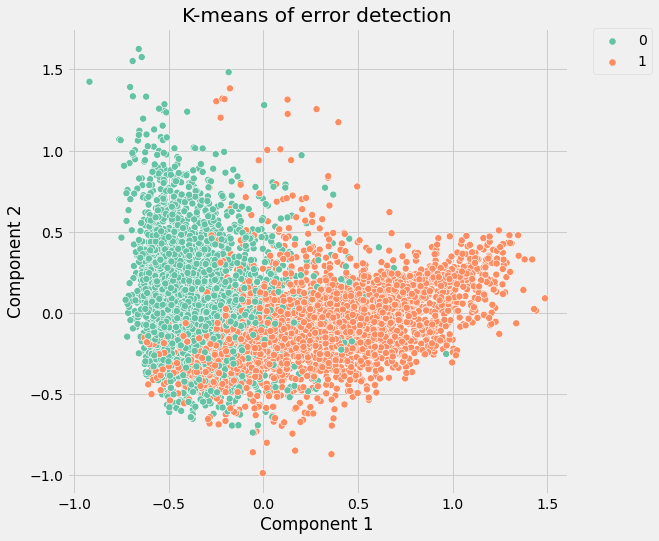

In [21]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))
scat = sns.scatterplot("Component 1","Component 2", s=50, data=pcadf,hue="true_label",palette="Set2")# style="predicted_cluster",
scat.set_title("K-means of error detection")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

In [41]:
sklearn.metrics.adjusted_rand_score(pipe.predict(test_img),test_lbl)

0.3773772795885345

C:\Users\pinto\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


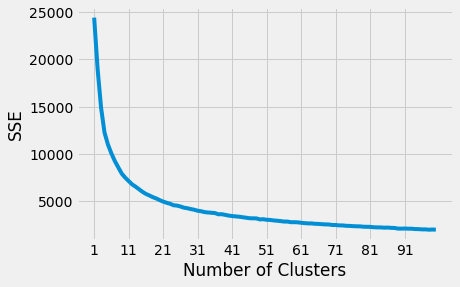

In [272]:
#Measure for the realistic number of clusters you can use
sse = []
for k in range(1, 101):
    kmeans = KMeans(n_clusters=k)#, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
plt.style.use("fivethirtyeight")
plt.plot(range(1, 101), sse)
plt.xticks(range(1, 101,10))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

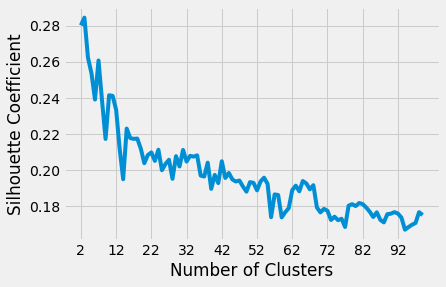

In [273]:
#Silhouette score also is a robust measure of the realistic number of clusters you could distinguish from this data
kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42}

silhouette_coefficients = []

for k in range(2, 100):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)
plt.style.use("fivethirtyeight")
plt.plot(range(2, 100), silhouette_coefficients)
plt.xticks(range(2, 100,10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [22]:
ppp = ['P/E','phyla','polarity','order','family','2D_shape','3D_shape','aperture_prefix','class','aperture_type','aperture_features','dispersal_unit']
effdf=pd.DataFrame()
#ppp=['error']

for a in ppp:
    csv = pd.read_csv('kmeans_in.csv', index_col=a)
    newdf = pd.DataFrame(csv)
    newdf = newdf[newdf['error'] == np.int64(0)]
    newdf = newdf.loc[newdf.index.dropna()]
    geometric_ft = ['Area','Eccentricity','Equivalent_diameter','Extent','Major_axis_length','Minor_axis_length','Perimeter']
    texture_ft = ['ASM','Contrast','Correlation','Dissimilarity','Energy','Entropy','Homogeneity','Solidity']

    newdf =newdf[['Area','Eccentricity','Equivalent_diameter','Extent','Major_axis_length','Minor_axis_length','Perimeter','ASM','Contrast','Correlation','Dissimilarity','Energy','Entropy','Homogeneity','Solidity']]           #.drop(['error','P/E','phyla','order','key','Unnamed: 0','Clump','Misread','family','2D_shape','3D_shape','aperture_prefix','class','aperture_type','aperture_features','ornamentation','other','taxonomy','image','dispersal_unit','min_max_size'],axis=1)
    try:
        newdf = newdf.drop('-')
    except:
        newdf = newdf
    try:
        newdf = newdf.drop('no suitable term')
    except:
        newdf = newdf
    c = newdf.index.size
    newdf,xdf,testdf= np.split(newdf,[int(c*0.8),int(c*0.81)])

    df_np = newdf.to_numpy()

    labels = pd.Series(newdf.index).apply(lambda x: str(x)).to_numpy()
    label_encoder = LabelEncoder()
    true_labels = label_encoder.fit_transform(labels)
    n_clusters = len(label_encoder.classes_)

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df_np)

    preprocessor = Pipeline([("scaler", MinMaxScaler()),("pca", PCA(n_components=6, random_state=42))])

    clusterer = Pipeline([("kmeans",KMeans(n_clusters=n_clusters,init="k-means++",n_init=50,max_iter=500,random_state=42))])
    pipe = Pipeline([("preprocessor", preprocessor),("clusterer", clusterer)])
    pipe.fit(df_np)

    preprocessed_data = pipe["preprocessor"].transform(df_np)
    predicted_labels = pipe["clusterer"]["kmeans"].labels_

    pcadf = pd.DataFrame(pipe["preprocessor"].transform(df_np),columns=["component_1", "component_2", "component_3", "component_4", "component_5", "component_6"])
    pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
    pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

    pipe.fit(newdf)

    preprocessed_data = pipe["preprocessor"].transform(newdf)
    predicted_labels = pipe["clusterer"]["kmeans"].labels_
    d = np.asarray(pipe.fit(newdf).predict(testdf))

    labels = pd.Series(testdf.index).apply(lambda x: str(x)).to_numpy()
    true_labels = testdf.index
    e = sklearn.metrics.adjusted_rand_score(true_labels, d)
    effdf = effdf.append(pd.Series(e,name=a))
effdf

,0
P/E,0.006509
phyla,-0.007702
polarity,-0.010318
order,0.205648
family,0.133814
2D_shape,0.079455
3D_shape,0.002420
aperture_prefix,0.057838
class,0.058160
aperture_type,0.054949
